In [44]:
import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime
from typing import Dict, List, Optional, Union, Any
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import io
import base64

####Feature names and descriptions for the heart disease dataset

In [45]:
FEATURE_INFO = {
    'age': {
        'name': 'Age',
        'unit': 'years',
        'normal_range': (30, 70),
        'clinical_context': 'Age is a risk factor for heart disease, increasing with age'
    },
    'sex': {
        'name': 'Sex',
        'unit': '',
        'values': {0: 'Female', 1: 'Male'},
        'clinical_context': 'Males have higher risk of heart disease than females'
    },
    'cp': {
        'name': 'Chest Pain Type',
        'unit': '',
        'values': {0: 'Typical angina', 1: 'Atypical angina', 2: 'Non-anginal pain', 3: 'Asymptomatic'},
        'clinical_context': 'Type of chest pain experienced; atypical symptoms may still indicate heart issues'
    },
    'trestbps': {
        'name': 'Resting Blood Pressure',
        'unit': 'mm Hg',
        'normal_range': (90, 120),
        'clinical_context': 'Elevated blood pressure increases cardiac workload and risk'
    },
    'chol': {
        'name': 'Serum Cholesterol',
        'unit': 'mg/dl',
        'normal_range': (125, 200),
        'clinical_context': 'High cholesterol contributes to plaque formation in arteries'
    },
    'fbs': {
        'name': 'Fasting Blood Sugar',
        'unit': '',
        'values': {0: 'FBS < 120 mg/dl', 1: 'FBS > 120 mg/dl'},
        'clinical_context': 'Elevated blood sugar may indicate diabetes, a heart disease risk factor'
    },
    'restecg': {
        'name': 'Resting ECG Results',
        'unit': '',
        'values': {0: 'Normal', 1: 'ST-T wave abnormality', 2: 'Left ventricular hypertrophy'},
        'clinical_context': 'ECG abnormalities may indicate existing heart conditions'
    },
    'thalach': {
        'name': 'Maximum Heart Rate',
        'unit': 'bpm',
        'normal_range': (120, 180),
        'clinical_context': 'Lower max heart rate may indicate reduced cardiac capacity'
    },
    'exang': {
        'name': 'Exercise Induced Angina',
        'unit': '',
        'values': {0: 'No', 1: 'Yes'},
        'clinical_context': 'Angina during exercise strongly associated with coronary artery disease'
    },
    'oldpeak': {
        'name': 'ST Depression',
        'unit': 'mm',
        'normal_range': (0, 0.5),
        'clinical_context': 'Depression induced by exercise relative to rest; indicates ischemia'
    },
    'slope': {
        'name': 'Peak Exercise ST Segment',
        'unit': '',
        'values': {0: 'Upsloping', 1: 'Flat', 2: 'Downsloping'},
        'clinical_context': 'Slope of peak exercise ST segment; downsloping indicates abnormality'
    },
    'ca': {
        'name': 'Major Vessels Colored by Fluoroscopy',
        'unit': '',
        'normal_range': (0, 0),
        'clinical_context': 'Number of major vessels with calcium deposits; more vessels indicate advanced disease'
    },
    'thal': {
        'name': 'Thalassemia',
        'unit': '',
        'values': {0: 'Normal', 1: 'Fixed defect', 2: 'Reversible defect', 3: 'Unknown'},
        'clinical_context': 'Blood disorder affecting oxygen carrying capacity; defects may indicate abnormal blood supply'
    }
}

#### Model training and prediction functions
##### Train a bagging ensemble of RandomForest and GradientBoosting models
    
    Args:
        data_path: Path to the CSV file containing heart disease data
        save_path: Directory to save the trained models and scalers
        
    Returns:
        Dictionary with trained models and preprocessing components

In [46]:
def train_bagging_ensemble(data_path, save_path='contents/'):
    """
    Train a bagging ensemble of RandomForest and GradientBoosting models

    Args:
        data_path: Path to the CSV file containing heart disease data
        save_path: Directory to save the trained models and scalers

    Returns:
        Dictionary with trained models and preprocessing components
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Load dataset
    df = pd.read_csv(data_path)
    df = df.dropna()

    # Features and target
    X = df.drop(columns=['target'])
    y = df['target']

    # Train/test split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Feature scaling - important for gradient boosting
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame to preserve column names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Create individual models for the ensemble
    rf_model1 = RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42, class_weight='balanced'
    )

    rf_model2 = RandomForestClassifier(
        n_estimators=200, max_depth=8, min_samples_leaf=3, random_state=84, class_weight='balanced'
    )

    gb_model1 = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42,
        subsample=0.8, min_samples_split=5
    )

    gb_model2 = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=4, random_state=84,
        subsample=0.7, min_samples_split=10
    )

    # Create voting ensemble (soft voting = average of probabilities)
    bagging_ensemble = VotingClassifier(
        estimators=[
            ('rf1', rf_model1),
            ('rf2', rf_model2),
            ('gb1', gb_model1),
            ('gb2', gb_model2),
        ],
        voting='soft'
    )

    # Fit models
    print("Training bagging ensemble...")
    bagging_ensemble.fit(X_train_scaled_df, y_train)

    # Evaluate ensemble
    ensemble_acc = bagging_ensemble.score(X_test_scaled_df, y_test)
    print(f"Ensemble Test Accuracy: {ensemble_acc:.4f}")

    # For uncertainty estimation, we also need individual models
    # Train each model independently to also use them for uncertainty estimation
    rf_model1.fit(X_train_scaled_df, y_train)
    rf_model2.fit(X_train_scaled_df, y_train)
    gb_model1.fit(X_train_scaled_df, y_train)
    gb_model2.fit(X_train_scaled_df, y_train)

    # Calculate feature statistics for normalization and abnormal feature detection
    feature_means = X_train.mean()
    feature_stds = X_train.std()

    # Save models and preprocessing components
    model_components = {
        'ensemble': bagging_ensemble,
        'rf_model1': rf_model1,
        'rf_model2': rf_model2,
        'gb_model1': gb_model1,
        'gb_model2': gb_model2,
        'scaler': scaler,
        'feature_means': feature_means,
        'feature_stds': feature_stds,
        'accuracy': ensemble_acc
    }

    # Save to disk
    joblib.dump(model_components, os.path.join(save_path, 'heart_model_ensemble.pkl'))

    return model_components

In [47]:
def load_model(model_path='heart_model_ensemble.pkl'):
    """Load the trained model components from disk"""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    return joblib.load(model_path)

In [48]:
def predict_heart_disease(patient_data, model_components, num_bootstrap_samples=50, z_score_threshold=1.5):
    """
    Predict heart disease risk with uncertainty quantification and clinical insights.

    Args:
        patient_data: Dictionary or DataFrame with patient features
        model_components: Dictionary containing trained model components
        num_bootstrap_samples: Number of bootstrap samples for uncertainty estimation
        z_score_threshold: Threshold for flagging abnormal features

    Returns:
        Dictionary with prediction results and clinical insights
    """
    # Extract components
    ensemble = model_components['ensemble']
    rf_model1 = model_components['rf_model1']
    rf_model2 = model_components['rf_model2']
    gb_model1 = model_components['gb_model1']
    gb_model2 = model_components['gb_model2']
    scaler = model_components['scaler']
    feature_means = model_components['feature_means']
    feature_stds = model_components['feature_stds']

    # Convert dict to DataFrame if needed
    if isinstance(patient_data, dict):
        patient_data = pd.DataFrame([patient_data])

    # Ensure all required features are present
    expected_features = feature_means.index.tolist()
    for feature in expected_features:
        if feature not in patient_data.columns:
            raise ValueError(f"Missing required feature: {feature}")

    # Scale patient data
    patient_data_scaled = pd.DataFrame(
        scaler.transform(patient_data),
        columns=patient_data.columns
    )

    # Basic prediction with the ensemble
    prediction_proba = ensemble.predict_proba(patient_data_scaled)[0, 1]
    prediction = 1 if prediction_proba >= 0.5 else 0

    # --- Enhanced uncertainty estimation ---
    # 1. Bootstrap sampling with noise
    bootstrap_probs = []
    for _ in range(num_bootstrap_samples):
        # Create bootstrapped sample with noise
        bootstrap_sample = patient_data_scaled.copy()
        for col in bootstrap_sample.columns:
            noise = np.random.normal(0, 0.05)  # Small gaussian noise
            if bootstrap_sample[col].dtype in [np.float64, np.int64]:
                bootstrap_sample[col] = bootstrap_sample[col] + noise

        # Get predictions from all individual models
        rf1_prob = rf_model1.predict_proba(bootstrap_sample)[0, 1]
        rf2_prob = rf_model2.predict_proba(bootstrap_sample)[0, 1]
        gb1_prob = gb_model1.predict_proba(bootstrap_sample)[0, 1]
        gb2_prob = gb_model2.predict_proba(bootstrap_sample)[0, 1]

        # Average the predictions
        avg_prob = (rf1_prob + rf2_prob + gb1_prob + gb2_prob) / 4
        bootstrap_probs.append(avg_prob)

    # 2. Calculate variance across models for this sample
    model_probs = [
        rf_model1.predict_proba(patient_data_scaled)[0, 1],
        rf_model2.predict_proba(patient_data_scaled)[0, 1],
        gb_model1.predict_proba(patient_data_scaled)[0, 1],
        gb_model2.predict_proba(patient_data_scaled)[0, 1]
    ]
    model_variance = np.var(model_probs)

    # 3. Combine both uncertainty measures (bootstrap and model variance)
    bootstrap_std = np.std(bootstrap_probs)
    combined_uncertainty = np.sqrt(bootstrap_std**2 + model_variance)

    # Scale to percentage (0-100%)
    # The scaling factor 4.0 is chosen to make typical uncertainty values range from 0-100%
    # Higher values might exceed 100% for extremely uncertain predictions
    uncertainty_percent = min(combined_uncertainty * 400, 100)
    reliability_percent = 100 - uncertainty_percent

    # --- Abnormal feature detection ---
    # Calculate z-scores using original (unscaled) data
    z_scores = (patient_data - feature_means) / feature_stds

    # Identify abnormal features
    abnormal_features = {}
    for col in z_scores.columns:
        z_val = z_scores.iloc[0][col]
        if abs(z_val) >= z_score_threshold:
            abnormal_features[col] = {
                'feature_name': FEATURE_INFO[col]['name'],
                'value': patient_data.iloc[0][col],
                'z_score': z_val,
                'direction': 'high' if z_val > 0 else 'low',
                'severity': 'severe' if abs(z_val) > 2.5 else 'moderate',
                'clinical_context': FEATURE_INFO[col]['clinical_context']
            }

            # Add human-readable value for categorical features
            if 'values' in FEATURE_INFO[col]:
                value = int(patient_data.iloc[0][col])
                if value in FEATURE_INFO[col]['values']:
                    abnormal_features[col]['readable_value'] = FEATURE_INFO[col]['values'][value]

            # Add units where applicable
            if 'unit' in FEATURE_INFO[col] and FEATURE_INFO[col]['unit']:
                abnormal_features[col]['unit'] = FEATURE_INFO[col]['unit']

    # Sort abnormal features by severity (absolute z-score)
    abnormal_features = dict(sorted(
        abnormal_features.items(),
        key=lambda x: abs(x[1]['z_score']),
        reverse=True
    ))

    # --- Feature importance for this prediction ---
    # Calculate feature importances
    feature_importances = ensemble.named_estimators_['rf1'].feature_importances_

    feature_contributions = {}
    for i, col in enumerate(feature_means.index):
        # Calculate personalized feature importance
        importance = feature_importances[i]
        contribution = importance * (1 + 0.5 * abs(z_scores.iloc[0][col]))

        if importance > 0.02:  # Only include significant contributions
            feature_contributions[col] = {
                'feature_name': FEATURE_INFO[col]['name'],
                'importance': round(importance, 3),
                'contribution': round(contribution, 3)
            }

            # Add human-readable value for categorical features
            if 'values' in FEATURE_INFO[col]:
                value = int(patient_data.iloc[0][col])
                if value in FEATURE_INFO[col]['values']:
                    feature_contributions[col]['value'] = FEATURE_INFO[col]['values'][value]
            else:
                feature_contributions[col]['value'] = float(patient_data.iloc[0][col])

                # Add units where applicable
                if 'unit' in FEATURE_INFO[col] and FEATURE_INFO[col]['unit']:
                    feature_contributions[col]['unit'] = FEATURE_INFO[col]['unit']

    # Sort feature contributions
    feature_contributions = dict(sorted(
        feature_contributions.items(),
        key=lambda x: x[1]['contribution'],
        reverse=True
    ))

    # --- Format results for clinical use ---
    risk_levels = {
        (0, 0.2): "Very Low",
        (0.2, 0.4): "Low",
        (0.4, 0.6): "Moderate",
        (0.6, 0.8): "High",
        (0.8, 1.0): "Very High"
    }

    risk_level = next(level for range_vals, level in risk_levels.items()
                     if range_vals[0] <= prediction_proba < range_vals[1] or range_vals[1] == 1.0)

    # Format date for the report
    today = datetime.now().strftime("%B %d, %Y")

    # Generate clinical insights
    clinical_insights = get_clinical_insights(prediction_proba, uncertainty_percent/100,
                                             abnormal_features, feature_contributions)

    # Format final results
    return {
        "prediction": {
            "heart_disease_probability": round(prediction_proba, 3),
            "binary_prediction": int(prediction),
            "risk_level": risk_level,
            "risk_category": "High Risk" if prediction_proba >= 0.5 else "Low Risk"
        },
        "uncertainty": {
            "uncertainty_percent": round(uncertainty_percent, 1),
            "reliability_percent": round(reliability_percent, 1),
            "assessment": "Prediction is " + (
                "highly reliable" if uncertainty_percent < 20 else
                "moderately reliable" if uncertainty_percent < 50 else
                "uncertain - consider additional tests"
            )
        },
        "abnormal_features": abnormal_features,
        "key_contributors": feature_contributions,
        "report_date": today,
        "clinical_insights": clinical_insights
    }


In [49]:
def get_clinical_insights(risk_prob, uncertainty, abnormal_features, key_contributors):
    """Generate clinical insights and recommendations based on prediction results"""

    insights = []
    recommendations = []

    # Risk level assessment
    if risk_prob < 0.2:
        insights.append("Patient shows minimal indicators of heart disease.")
        recommendations.append("Standard preventive care and lifestyle counseling advised.")
    elif risk_prob < 0.4:
        insights.append("Patient shows some risk factors for heart disease.")
        recommendations.append("Consider lifestyle modifications and monitoring of risk factors.")
    elif risk_prob < 0.6:
        insights.append("Patient shows moderate risk factors for heart disease.")
        recommendations.append("Further cardiac assessment recommended. Consider non-invasive testing.")
    elif risk_prob < 0.8:
        insights.append("Patient shows significant risk factors for heart disease.")
        recommendations.append("Comprehensive cardiac evaluation indicated. Consider stress test and echocardiogram.")
    else:
        insights.append("Patient shows strong indicators of heart disease.")
        recommendations.append("Urgent cardiology referral advised. Consider cardiac catheterization if symptomatic.")

    # Uncertainty insights
    if uncertainty > 0.5:
        insights.append("Model shows significant uncertainty in this prediction.")
        recommendations.append("Consider additional diagnostic tests to confirm cardiovascular status.")

    # Feature-specific insights
    for feature, details in abnormal_features.items():
        if feature == 'cp' and details['value'] in [0, 1, 2]:
            insights.append(f"Patient reports {details.get('readable_value', details['value'])}, which may indicate angina.")
            if details['value'] == 0:  # Typical angina
                recommendations.append("Evaluate for stable coronary artery disease.")

        elif feature == 'thalach' and details['direction'] == 'low':
            insights.append("Maximum heart rate during exercise is abnormally low, suggesting reduced cardiac capacity.")
            recommendations.append("Consider evaluation for chronotropic incompetence or ischemic heart disease.")

        elif feature == 'oldpeak' and details['direction'] == 'high':
            insights.append("Significant ST depression observed during exercise, suggesting myocardial ischemia.")
            recommendations.append("ECG monitoring during exercise recommended to assess for ischemic changes.")

        elif feature == 'chol' and details['direction'] == 'high':
            insights.append("Elevated cholesterol levels may contribute to atherosclerotic disease.")
            recommendations.append("Lipid management indicated. Consider statin therapy if appropriate.")

        elif feature == 'trestbps' and details['direction'] == 'high':
            insights.append("Elevated resting blood pressure increases cardiac workload and stroke risk.")
            recommendations.append("Blood pressure management recommended. Target <130/80 mmHg.")

        elif feature == 'ca' and details['value'] > 0:
            insights.append(f"Fluoroscopy shows {int(details['value'])} major vessel(s) with calcium deposits.")
            recommendations.append("Presence of calcified vessels indicates atherosclerotic disease.")

        elif feature == 'exang' and details['value'] == 1:
            insights.append("Patient experiences angina during exercise, strongly associated with CAD.")
            recommendations.append("Anti-anginal medication may be indicated.")

        elif feature == 'thal' and details['value'] in [1, 2]:
            thal_value = details.get('readable_value', details['value'])
            insights.append(f"Thallium scan shows {thal_value}, indicating abnormal blood flow.")
            recommendations.append("Consider myocardial perfusion imaging to assess for reversible ischemia.")

    # Return combined insights
    return {
        "key_insights": insights[:5],  # Limit to top 5 insights
        "recommendations": recommendations[:5]  # Limit to top 5 recommendations
    }

In [50]:
def generate_report(results, include_visualization=False):
    """
    Generate a formatted clinical report from prediction results

    Args:
        results: Dictionary of prediction results
        include_visualization: Whether to include plots in the report

    Returns:
        String containing the formatted report
    """
    report = []

    # Header
    report.append("=" * 60)
    report.append("CARDIAC RISK ASSESSMENT REPORT")
    report.append("=" * 60)
    report.append(f"Report Date: {results['report_date']}")
    report.append("")

    # Risk assessment
    report.append("RISK ASSESSMENT")
    report.append("-" * 30)
    report.append(f"Heart Disease Risk: {results['prediction']['risk_level']} ({results['prediction']['heart_disease_probability']*100:.1f}%)")
    report.append(f"Risk Category: {results['prediction']['risk_category']}")
    report.append(f"Prediction Reliability: {results['uncertainty']['reliability_percent']:.1f}%")
    report.append(f"Uncertainty Level: {results['uncertainty']['uncertainty_percent']:.1f}%")
    report.append(f"Assessment: {results['uncertainty']['assessment']}")
    report.append("")

    # Key insights
    report.append("CLINICAL INSIGHTS")
    report.append("-" * 30)
    for i, insight in enumerate(results['clinical_insights']['key_insights'], 1):
        report.append(f"{i}. {insight}")
    report.append("")

    # Abnormal findings
    report.append("ABNORMAL CLINICAL FINDINGS")
    report.append("-" * 30)
    if results['abnormal_features']:
        for feature, details in results['abnormal_features'].items():
            direction = "↑" if details['direction'] == 'high' else "↓"

            if 'readable_value' in details:
                value_text = f"{details['readable_value']}"
            elif 'unit' in details:
                value_text = f"{details['value']} {details['unit']}"
            else:
                value_text = f"{details['value']}"

            report.append(f"- {details['feature_name']}: {value_text} {direction}")
            report.append(f"  Severity: {details['severity'].title()} (z-score: {details['z_score']:.2f})")
            report.append(f"  Note: {details['clinical_context']}")
            report.append("")
    else:
        report.append("- No significantly abnormal features detected")
        report.append("")

    # Recommendations
    report.append("CLINICAL RECOMMENDATIONS")
    report.append("-" * 30)
    for i, rec in enumerate(results['clinical_insights']['recommendations'], 1):
        report.append(f"{i}. {rec}")
    report.append("")

    # Return the formatted report
    return "\n".join(report)


In [51]:
def visualize_patient_data(patient_data, feature_means, feature_stds, result):
    """Create visualization of patient data relative to population norms"""
    if not isinstance(patient_data, pd.DataFrame):
        patient_data = pd.DataFrame([patient_data])

    # Calculate z-scores
    z_scores = (patient_data - feature_means) / feature_stds

    # Select numerical features for visualization
    num_features = [col for col in z_scores.columns
                   if col not in ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']]

    # Create figure
    plt.figure(figsize=(12, 6))

    # Create bar plot of z-scores
    bars = plt.bar(range(len(num_features)), z_scores[num_features].iloc[0], color='skyblue')

    # Color bars based on abnormality
    for i, feature in enumerate(num_features):
        z_val = z_scores[feature].iloc[0]
        if abs(z_val) > 1.5:
            bars[i].set_color('salmon' if z_val > 0 else 'lightgreen')

    # Add reference lines
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axhline(y=1.5, color='red', linestyle='--', alpha=0.5)
    plt.axhline(y=-1.5, color='red', linestyle='--', alpha=0.5)

    # Set labels and title
    plt.xticks(range(len(num_features)), [FEATURE_INFO[f]['name'] for f in num_features], rotation=45, ha='right')
    plt.ylabel('Standard Deviations from Mean')
    plt.title(f'Patient Feature Profile (Risk Level: {result["prediction"]["risk_level"]})')

    # Add risk probability and reliability
    plt.text(0.02, 0.95, f'Heart Disease Risk: {result["prediction"]["heart_disease_probability"]:.1%}',
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.text(0.02, 0.89, f'Prediction Reliability: {result["uncertainty"]["reliability_percent"]:.1f}%',
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()

    # Convert plot to base64 for embedding in web applications
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()

    return img_str


Heart Disease Prediction System
Loading pre-trained model...
CARDIAC RISK ASSESSMENT REPORT
Report Date: April 10, 2025

RISK ASSESSMENT
------------------------------
Heart Disease Risk: Low (22.9%)
Risk Category: Low Risk
Prediction Reliability: 43.0%
Uncertainty Level: 57.0%
Assessment: Prediction is uncertain - consider additional tests

CLINICAL INSIGHTS
------------------------------
1. Patient shows some risk factors for heart disease.
2. Model shows significant uncertainty in this prediction.

ABNORMAL CLINICAL FINDINGS
------------------------------
- Age: 158.0 years ↑
  Severity: Severe (z-score: 11.35)
  Note: Age is a risk factor for heart disease, increasing with age

- Fasting Blood Sugar: FBS > 120 mg/dl ↑
  Severity: Moderate (z-score: 2.35)
  Note: Elevated blood sugar may indicate diabetes, a heart disease risk factor

- Chest Pain Type: Asymptomatic ↑
  Severity: Moderate (z-score: 2.03)
  Note: Type of chest pain experienced; atypical symptoms may still indicate he

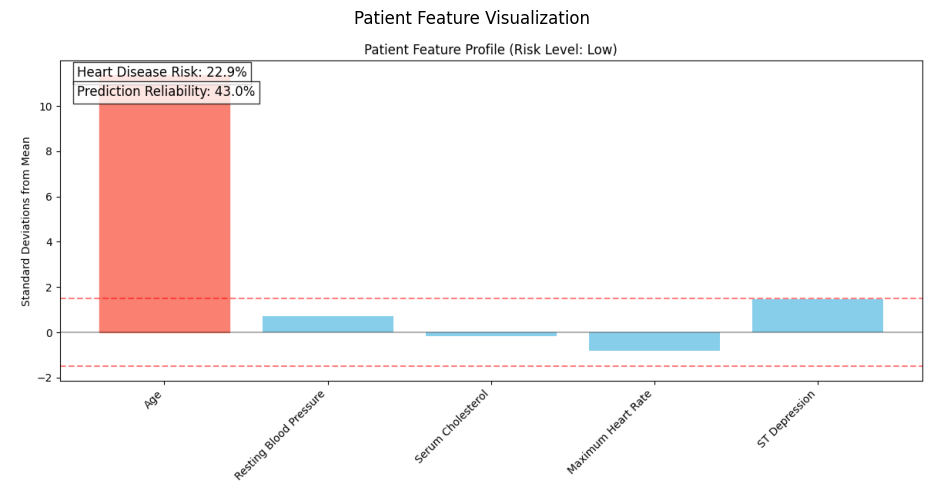

In [55]:
def example_prediction():
    """Run a sample prediction with full clinical report and visualization"""

    # Train model or load if already trained
    model_path = 'contents/heart_model_ensemble.pkl'
    if os.path.exists(model_path):
        print("Loading pre-trained model...")
        model_components = load_model(model_path)
    else:
        print("Training new model...")
        model_components = train_bagging_ensemble('/content/heart.csv')

    # Sample patient input
    sample_patient = {
        'age': 158,
        'sex': 1,          # Male
        'cp': 3,           # Asymptomatic
        'trestbps': 145,   # Elevated
        'chol': 240,       # Elevated
        'fbs': 1,          # Fasting blood sugar > 120 mg/dl
        'restecg': 0,      # Normal
        'thalach': 131,    # Lower than expected
        'exang': 1,        # Exercise induced angina
        'oldpeak': 2.8,    # Significant ST depression
        'slope': 1,        # Flat
        'ca': 2,           # 2 vessels colored
        'thal': 2          # Reversible defect
    }

    # Predict
    result = predict_heart_disease(sample_patient, model_components)

    # Generate and print report
    report = generate_report(result)
    print(report)

    # Visualize
    import matplotlib.pyplot as plt
    import base64
    import io

    img_base64 = visualize_patient_data(sample_patient,
                                        model_components['feature_means'],
                                        model_components['feature_stds'],
                                        result)

    # Decode and show the image
    img_bytes = base64.b64decode(img_base64)
    img_stream = io.BytesIO(img_bytes)
    img = plt.imread(img_stream, format='png')

    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Patient Feature Visualization')
    plt.show()

    return result

if __name__ == "__main__":
    print("Heart Disease Prediction System")
    print("=" * 50)
    result = example_prediction()